In [1]:
!pip install matplotlib-venn

In [2]:
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

4423680/4422102 [==============================] - 0s 0us/step


Question 1: Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use "from keras.datasets import fashion_mnist" for getting the fashion mnist dataset.

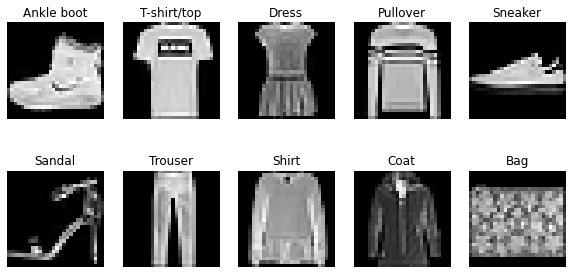

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

plottedClass =  [False for i in range(10)] 
count=0
for i in range(25):
    if  plottedClass[Y_train[i]]==False:
      plt.subplot(2,5,count+1).set_title(labels[Y_train[i]]) 
      plt.imshow(X_train[i],cmap='gray')
      plt.axis("off")
      plottedClass[Y_train[i]]=True
      count=count+1

plt.show()

**Backpropagation code stage1.**

In [4]:
import numpy as np

In [5]:
from sklearn.preprocessing import OneHotEncoder

print("Train data shape {} : Train label shape {}".format(X_train.shape,Y_train.shape))
print("Test data shape {} : Test label shape {}".format(X_test.shape,Y_test.shape))

#flatten the Xtrain and X_test
X_tr=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_ts=X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

#create one hot encoding of the labels
Y_tr=OneHotEncoder().fit_transform(Y_train.reshape(-1,1)).toarray()
Y_ts=OneHotEncoder().fit_transform(Y_test.reshape(-1,1)).toarray()

print("After reshaping...")

print("Train data shape {} : Train label shape {}".format(X_tr.shape,Y_tr.shape))
print("Test data shape {} : Test label shape {}".format(X_ts.shape,Y_ts.shape))

#normalizing the train data...
X_tr=X_tr/255
X_ts=X_ts/255

Train data shape (60000, 28, 28) : Train label shape (60000,)
Test data shape (10000, 28, 28) : Test label shape (10000,)
After reshaping...
Train data shape (60000, 784) : Train label shape (60000, 10)
Test data shape (10000, 784) : Test label shape (10000, 10)


In [41]:
class Activation:

  def Sigmoid(self,x):
    return 1/(1+np.exp(-x))

  def Softmax(self,x):
    numr=np.exp(x)
    return numr/sum(np.exp(x))

  def Relu(self,x):
    return 1

  def Tanh(self,x):
    numr=np.exp(x)-np.exp(-x)
    denom=np.exp(x)+np.exp(-x)
    return numr/denom

  def Derivative_Sigmoid(self,x):
    s=1/(1+np.exp(-x))
    return s*(1-s)

  def Derivative_Relu(self,x):
    return 1  

  def Derivative_Tanh(self,x):
    return 1-Tanh(x)**2

  def Linear(self,x):
    return x


In [42]:
class Loss:

  #Takes ypred as [[],[]] and y as [[],[]]
  def CategoricalCrossEntropy(self,ypred,y):
    class_idx=np.argmax(y,axis=1)
    cce_loss=0
    for i in range(len(class_idx)):
      cce_loss+=(-1)*np.log2(ypred[i][class_idx[i]])
    return cce_loss


  def meansquarederror(self,ypred,y):

    #check for correct squared loss function
    return np.sum((ypred-y)**2)



In [73]:
class HLayer:

  def __init__(self,num_inputs,num_neurons,activation):
    
    #np.random.seed(2)
    self.num_inputs=num_inputs
    self.num_neurons=num_neurons
    self.activation=activation

    self.W=np.random.normal(loc=0.0,scale=2.0,size=(self.num_neurons,self.num_inputs))
    self.b=np.random.normal(loc=0.0,scale=2.0,size=(self.num_neurons,))

    self.del_h=np.zeros((self.num_neurons,))
    self.del_a=np.zeros((self.num_neurons,))
    self.delW=np.zeros((self.num_neurons,self.num_inputs))
    self.delb=np.zeros((self.num_neurons,))

    self.aL=np.zeros((self.num_neurons,))
    self.hL=np.zeros((self.num_neurons,))
  

  def show_details(self):
    print("Hidden Layer..")
    
    print("number of neurons :",self.num_neurons)
    print("number of inputs :",self.num_inputs)
    print("shape of weights :",self.W.shape)
    print("shape of biases :",self.b.shape)
    print("shape of hL :",self.hL.shape)
    print("shape of aL :",self.aL.shape)


  def Forward(self,h_L_1):
    
    
    self.aL=np.dot(self.W,h_L_1)+self.b
    ac=Activation()
    
    if self.activation=="Relu":
      self.hL=ac.Relu(self.aL)

    if self.activation=="Tanh":
      self.hL=ac.Tanh(self.aL)
    
    else:
      self.hL=ac.Sigmoid(self.aL)

    


  def get_gradients(self,nextW,next_aL,Prev_hL):
      
      self.del_h=np.dot((nextW).T,next_aL)

      #gradients wrt pre activation for different Activation function used..
      if self.activation=="Relu":
        self.del_a=(self.del_h)*(Activation().Derivative_Relu(self.aL))

      elif self.activation=="Tanh":
        self.del_a=(self.del_h)*(Activation().Derivative_Tanh(self.aL))
      
      else:
        self.del_a=(self.del_h)*(Activation().Derivative_Sigmoid(self.aL))


      self.delW=np.dot(self.del_a.reshape(-1,1),Prev_hL.reshape(1,-1))
      self.delb=self.del_a

  def update_gradients(self,eta):

    self.W=self.W-eta*self.delW
    self.b=self.b-eta*self.delb
    
  def reset_gradients(self):
    
    self.del_h=np.zeros((self.num_neurons,))
    self.del_a=np.zeros((self.num_neurons,))
    self.delW=np.zeros((self.num_neurons,self.num_inputs))
    self.delb=np.zeros((self.num_neurons,))

  

In [54]:
class OPLayer:

  def __init__(self,num_inputs,num_class,activation):
    
    #np.random.seed(2)
    self.num_inputs=num_inputs
    self.num_neurons=num_class
    self.activation=activation

    #weight initializations..
    self.W=np.random.normal(loc=0.0,scale=2.0,size=(self.num_neurons,self.num_inputs))
    self.b=np.random.normal(loc=0.0,scale=2.0,size=(self.num_neurons,))

    self.aL=np.zeros((self.num_neurons,))
    self.hL=np.zeros((self.num_neurons,))
    self.del_h=np.zeros((self.num_neurons,))
    self.del_a=np.zeros((self.num_neurons,))
    self.delW=np.zeros((self.num_neurons,self.num_inputs))
    self.delb=np.zeros((self.num_neurons,))


  def show_details(self):
    print("Output Layer..")
    
    print("number of neurons :",self.num_neurons)
    print("number of inputs :",self.num_inputs)
    print("shape of weights :",self.W.shape)
    print("shape of biases :",self.b.shape)
    print("shape of hL :",self.hL.shape)
    print("shape of aL :",self.aL.shape)
   


  def Forward(self,h_L_1):
    
    self.aL=np.dot(self.W,h_L_1)+self.b
    ac=Activation()

    if self.activation=="Softmax":
      self.hL=ac.Softmax(self.aL)
    
    else:
      self.hL=ac.Linear(self.aL)



  
  def get_gradients(self,Y_hat,Y,prev_hL):
      
      if self.activation=="Softmax":
        for i in range(len(Y_hat)):
          self.del_h+=(-1/Y_hat[i][np.argmax(Y[i])]*Y[i])

        for i in range(len(Y_hat)):  
          self.del_a+=(Y_hat[i]-Y[i])
      
      #write the gradients formula for linear activation...
      else:
        pass

      self.delW=np.dot(self.del_a.reshape(-1,1),prev_hL.reshape(1,-1))
      self.delb=self.del_a


  def update_gradients(self,eta):

    self.W=self.W-eta*self.delW
    self.b=self.b-eta*self.delb

  def reset_gradients(self):
    self.del_h=np.zeros((self.num_neurons,))
    self.del_a=np.zeros((self.num_neurons,))
    self.delW=np.zeros((self.num_neurons,self.num_inputs))
    self.delb=np.zeros((self.num_neurons,))



In [45]:
class IpLayer:

  def __init__(self,num_neurons):
    self.num_neurons=num_neurons
    self.hL=np.zeros((self.num_neurons,))

  def show_details(self):
    print("Input Layer")
    print("for input layer the hL :",self.hL.shape)


  def Forward(self,x):
    self.hL=x


In [46]:
class NN:

  def __init__(self,input_shape,num_hlayers,neurons,activations,output_shape):

    self.input_shape=input_shape
    self.output_shape=output_shape
    self.num_hlayers=num_hlayers
    self.neurons=neurons
    self.HLAc=activations[0]
    self.OPAc=activations[1]

    self.Layers=[]
    self.eta=1e-3
    self.loss=0.0

    #used to store the predicted probabilities of passed data
    self.Y_hat=[]

  
  def create_architecture(self):

    #create input layer
    self.Layers.append(IpLayer(self.input_shape))

    #hidden layers..
    for layer in range(1,self.num_hlayers+1):
      
      ip_shape=self.Layers[layer-1].num_neurons
      self.Layers.append(HLayer(ip_shape,self.neurons[layer-1],self.HLAc))

    #output layer..

    self.Layers.append(OPLayer(self.Layers[self.num_hlayers].num_neurons,self.output_shape,self.OPAc))  


  def Structural_Desc(self):
    
    for i in range(0,self.num_hlayers+2):
      print("Layer Number : ",i)
      self.Layers[i].show_details()
      print("--"*50)


  def Feed_Forward(self,X_train,Y_train):
    self.loss=0
    self.Y_hat=[]
    
    for i in range(X_train.shape[0]):
      #get the data in input layer
      self.Layers[0].Forward(X_train[i])
      #pass the data to the hl+ol
      for j in range(1,self.num_hlayers+2):
        h_L_1=self.Layers[j-1].hL
        self.Layers[j].Forward(h_L_1)

      ypred=self.Layers[self.num_hlayers+1].hL
      self.Y_hat.append(ypred)
      
    self.loss=Loss().CategoricalCrossEntropy(self.Y_hat,Y_train)
     

  def Back_Propogation(self,Y):

    #get gradients for output layer first..
    prev_hL=self.Layers[self.num_hlayers].hL
    self.Layers[self.num_hlayers+1].get_gradients(self.Y_hat,Y,prev_hL)

    #getting gradients for hidden layers..
    for i in range(self.num_hlayers,0,-1):

      prev_hL=self.Layers[i-1].hL
      next_W=self.Layers[i+1].W
      next_aL=self.Layers[i+1].aL
      self.Layers[i].get_gradients(next_W,next_aL,prev_hL)

      
  #update gradients for each layer...
  def update_gradients(self):
    
    for i in range(1,self.num_hlayers+2):
      self.Layers[i].update_gradients(self.eta)

  #reset gradients for each layer...
  def reset_gradients(self):

    for i in range(1,self.num_hlayers+2):
      self.Layers[i].reset_gradients()
    
    self.loss=0


**Training..**

In [83]:
#considering this subset of data as train data..
X_sample=X_tr[:1000]
Y_sample=Y_tr[:1000]

In [84]:
def Batch_GD(X,Y,max_epochs):
  Lossr=[]

  arch1=NN(784,3,[128,64,32],['Sigmoid','Softmax'],10)
  arch1.create_architecture()
  #arch1.Structural_Desc()

  #batch gradient descent..
  for i in range(max_epochs):
    arch1.Feed_Forward(X,Y)
    Lossr.append(arch1.loss)
  
    arch1.Back_Propogation(Y_sample)
    arch1.update_gradients()
    arch1.reset_gradients()
  
  plt.plot(np.arange(1,max_epochs+1),Lossr)
  plt.xlabel("epochs")
  plt.ylabel("Loss")

  print("After training with BAtchGD...")
  arch1.Feed_Forward(X,Y)
  print("Loss is :",arch1.loss)
  cp=np.sum(np.argmax(np.array(arch1.Y_hat),axis=1)==np.argmax(Y,axis=1))/len(Y)
  print("Fraction of correctly predicted datapoints: ",cp)


In [80]:
#stochastic gradient descent...
def SGD(X,Y,max_epochs):

  arch1=NN(784,3,[128,64,32],['Sigmoid','Softmax'],10)
  arch1.create_architecture()
  #arch1.Structural_Desc()

  Loss_ep=[]
  for i in range(max_epochs):

    n=X.shape[0]

    for dpi in range(n):

      arch1.Feed_Forward(X[dpi].reshape(1,-1),Y[dpi].reshape(1,-1))

      arch1.Back_Propogation(Y[dpi])
      arch1.update_gradients()
      arch1.reset_gradients()

    #calculate the loss after 1 epoch...
    arch1.Feed_Forward(X,Y)
    Loss_ep.append(arch1.loss)

  plt.plot(np.arange(1,max_epochs+1),Loss_ep)
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.title("SGD")


  print("After training with SGD...")
  arch1.Feed_Forward(X,Y)
  print("Loss is :",arch1.loss)
  cp=np.sum(np.argmax(np.array(arch1.Y_hat),axis=1)==np.argmax(Y,axis=1))/len(Y)
  print("Fraction of correctly predicted datapoints: ",cp)




Layer Number :  0
Input Layer
for input layer the hL : (784,)
----------------------------------------------------------------------------------------------------
Layer Number :  1
Hidden Layer..
number of neurons : 128
number of inputs : 784
shape of weights : (128, 784)
shape of biases : (128,)
shape of hL : (128,)
shape of aL : (128,)
----------------------------------------------------------------------------------------------------
Layer Number :  2
Hidden Layer..
number of neurons : 64
number of inputs : 128
shape of weights : (64, 128)
shape of biases : (64,)
shape of hL : (64,)
shape of aL : (64,)
----------------------------------------------------------------------------------------------------
Layer Number :  3
Hidden Layer..
number of neurons : 32
number of inputs : 64
shape of weights : (32, 64)
shape of biases : (32,)
shape of hL : (32,)
shape of aL : (32,)
----------------------------------------------------------------------------------------------------
Layer Number : 

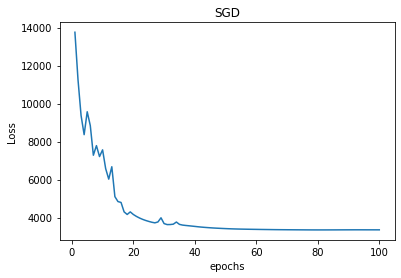

In [85]:
SGD(X_sample,Y_sample,100)

Layer Number :  0
Input Layer
for input layer the hL : (784,)
----------------------------------------------------------------------------------------------------
Layer Number :  1
Hidden Layer..
number of neurons : 128
number of inputs : 784
shape of weights : (128, 784)
shape of biases : (128,)
shape of hL : (128,)
shape of aL : (128,)
----------------------------------------------------------------------------------------------------
Layer Number :  2
Hidden Layer..
number of neurons : 64
number of inputs : 128
shape of weights : (64, 128)
shape of biases : (64,)
shape of hL : (64,)
shape of aL : (64,)
----------------------------------------------------------------------------------------------------
Layer Number :  3
Hidden Layer..
number of neurons : 32
number of inputs : 64
shape of weights : (32, 64)
shape of biases : (32,)
shape of hL : (32,)
shape of aL : (32,)
----------------------------------------------------------------------------------------------------
Layer Number : 

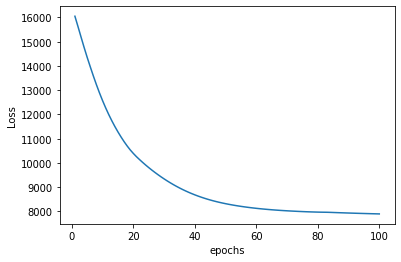

In [86]:
Batch_GD(X_sample,Y_sample,100)